<a href="https://colab.research.google.com/github/kalakhushi18/Deep-Learning/blob/main/HW2Part2_khushi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2 Part 2

Due Date: 12.01.2025

Total Points: 100

**Assignment Description**

In this assignment, you will implement a Recurrent Neural Network from using PyTorch and train it on the MNIST dataset for classification. You'll go through the entire machine learning pipeline from data preprocessing to model evaluation.

Good luck!

### **Objective**

The main goal of the Project is to classiy images of digitized MNIST handwritten digit under 10 classes from 0-9 using a RNN neural network architecture. it represents a H X W table, with the value of each element storing the intensity of the corresponding pixel.

In the following notebook we will analyse the three architectures of RNN that are Simple RNN, GRU and LSTM for the MNIST Classification task. For baseline model we have chosen Logistic Regression Neural Network.

### Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

### Setting Seed and Device

In [ ]:
#seed function
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("Using device", device)

Using device cuda


### Data Loading and Processing - MNIST Dataset

 We prepare the MNIST dataset, normalize images, and create dataloaders.

In [ ]:
# Step 1: Data Preprocessing
BATCH_SIZE = 64
TRANSFORM = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#downloading train and test set
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=TRANSFORM, download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=TRANSFORM, download=True)

# defining dataloader for shuffling and batching
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

### Exploratory Data Analysis

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28.


In [ ]:
# Number of Images
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

# Shape of Image
print("Shape of Mnist Train Set Image: ",mnist_train[0][0].shape )
print("Shape of Mnist Test Set Image: ",mnist_test[0][0].shape )

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000
Shape of Mnist Train Set Image:  torch.Size([1, 28, 28])
Shape of Mnist Test Set Image:  torch.Size([1, 28, 28])


#### Data Visualization

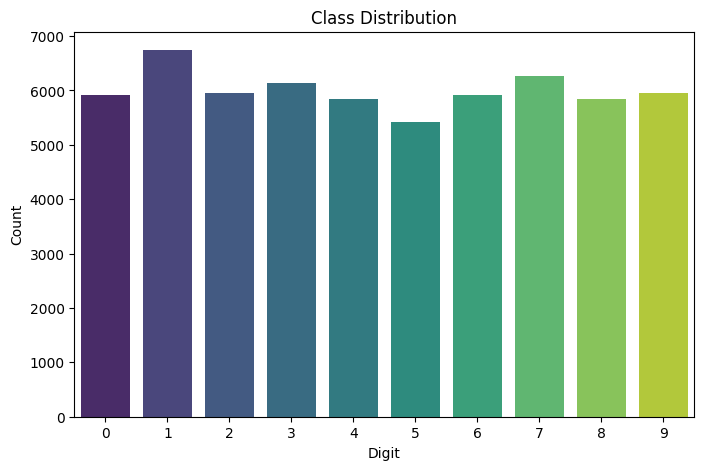

In [ ]:
# Class Distribution in Train set
labels = [label for _, label in mnist_train]
plt.figure(figsize=(8, 5))
sns.countplot(x=labels, palette='viridis')
plt.title('Class Distribution in Mnist Train Set')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

Almost all digits have similar number of class labels distribution, no particular major bias could be observed

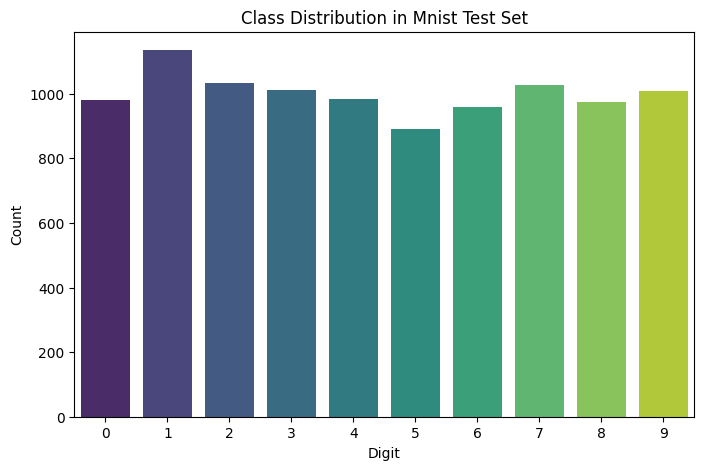

In [ ]:
labels = [label for _, label in mnist_test]
plt.figure(figsize=(8, 5))
sns.countplot(x=labels, palette='viridis')
plt.title('Class Distribution in Mnist Test Set')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

In Test set also there could not be a major bias observed

Plotting Images of MNIST Dataset

The label for this image: 4


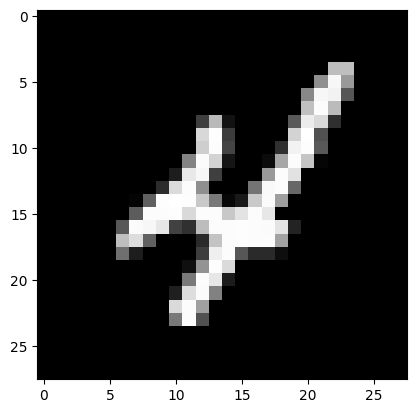

In [ ]:
# Pick out the 10th (0-indexed) example from the training set
image, label = mnist_train[9]

# Plot the image
image = image.reshape([28,28])
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

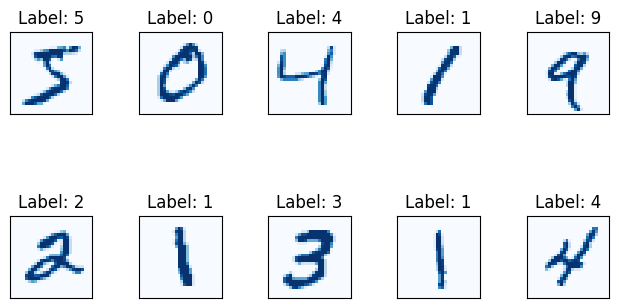

In [ ]:
# Checking more images
fig = plt.figure()
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.tight_layout()
  plt.imshow(mnist_train[i][0].squeeze(), interpolation='none', cmap='Blues')
  plt.title(f"Label: {mnist_train[i][1]}")
  plt.xticks([])
  plt.yticks([])

### Building Basline Model: Logistic Regression

In [ ]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(28*28, 10)

    def forward(self, x):
        return self.lin(x)

In [ ]:
# Training Function
def train_model(model, criterion, optimizer, trainloader, epochs=5):

    loss_history = []
    for epoch in range(epochs):

        total_loss = 0
        for images, labels in tqdm(trainloader):

            images, labels = images.to(device), labels.to(device)

            # Zero out Gradients
            optimizer.zero_grad()

            # Forward Pass
            x = images.view(-1, 28*28)
            y = model(x)

            # Calculating Loss
            loss = criterion(y, labels)

            # Backward Pass
            loss.backward()
            optimizer.step()  # Optimizing Gradient

            # Cumulating loss
            total_loss += loss.item()
        loss_history.append(total_loss / len(trainloader))
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(trainloader):.4f}')

    return loss_history

In [ ]:
#testing function
def evaluate_model(model, testloader, data_set_type):

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(testloader):

            # Shifting Images to device
            images, labels = images.to(device), labels.to(device)

            # Forward Pass
            x = images.view(-1, 28*28)
            y = model(x)
            predictions = torch.argmax(y, dim=1)   # taking the highest probability class
            total += labels.size(0)
            correct += torch.sum((predictions == labels).float())

    # Calculating Accuracy
    acc = 100 * correct / total
    print(f'Accuracy for {data_set_type}: {acc:.2f}%')



Training Logistic Regression Model

In [ ]:
# Train Linear Model
linear_model = MNIST_Logistic_Regression().to(device)

# Learning Rate
LEARNING_RATE = 0.01
EPOCHS = 20

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_model.parameters(), lr= LEARNING_RATE)

print("Training Linear Model:")
linear_loss = train_model(linear_model, criterion, optimizer, train_loader, EPOCHS)


Training Linear Model:


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5551


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2, Loss: 0.5345


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Loss: 0.5645


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4, Loss: 0.5468


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Loss: 0.5573


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6, Loss: 0.5468


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Loss: 0.5602


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8, Loss: 0.5849


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Loss: 0.5585


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, Loss: 0.5609


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11, Loss: 0.5621


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12, Loss: 0.5334


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13, Loss: 0.5621


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14, Loss: 0.5433


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15, Loss: 0.5502


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16, Loss: 0.5753


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17, Loss: 0.5677


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18, Loss: 0.5528


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19, Loss: 0.5426


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20, Loss: 0.5396


Testing Linear Model

In [ ]:
# evaluation on Test set
evaluate_model(linear_model, train_loader, "Train set" )
evaluate_model(linear_model, test_loader, "Test set")

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy for Train set: 90.93%


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy for Test set: 89.82%


**Accuracy achieved in Logistic Regression Basline Model**

Train Set = 90.93%

Test Set = 89.82%


### Building Neural Network Class: Recurrent Neural Network

ecurrent Neural Networks (RNNs) are widely used for sequence data tasks such as time series forecasting, language modeling, and more. A RNNModel processes images as sequences of 28 time steps, each of size 28.

In [ ]:
# parameters
input_size = 28  #MNIST images are 28x28
sequence_length = 28  #we treat the rows as a sequence of 28 inputs.
num_layers = 2  #Number of RNN Layers
hidden_size = 256  #The number of hidden units in the RNN’s hidden layer.
num_classes = 10   # 0-9 classes

In [ ]:
# RNN
class RNNModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)  #A fully connected layer that maps the last hidden state of the RNN to the output classes.

    def forward(self, x):
        x = x.view(-1, 28, 28)  # (batch, sequence, input)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) #Creates an initial hidden state h0 of shape (num_layers, batch_size, hidden_size), initialized to zeros.
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :]) #selects the hidden state of the last time step (i.e., after reading the entire sequence).

Training RNN Model

In [ ]:
#Initializing RNN Model
rnn_model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(device)
# Learning Rate
LEARNING_RATE = 0.001
EPOCHS = 20

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr= LEARNING_RATE)

#Training RNN
rnn_loss = train_model(rnn_model, criterion, optimizer, train_loader, EPOCHS)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5580


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2, Loss: 0.2734


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1987


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1702


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1548


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6, Loss: 0.1456


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1610


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8, Loss: 0.1408


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Loss: 0.1445


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, Loss: 0.1198


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11, Loss: 0.1229


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12, Loss: 0.1307


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13, Loss: 0.1439


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14, Loss: 0.1484


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15, Loss: 0.1092


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16, Loss: 0.1255


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17, Loss: 0.1414


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18, Loss: 0.1361


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19, Loss: 0.1425


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20, Loss: 0.1351


Testing RNN Model

In [ ]:
evaluate_model(rnn_model, train_loader, "Train set")
evaluate_model(rnn_model, test_loader, "Test set")

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy for Train set: 96.42%


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy for Test set: 95.97%


**Accuracy achieved in RNN model is higher than the Basline Model**

Train Set = 96.42%

Test Set = 95.97%

### GRU (Gated Recurrent Unit)

GRU is designed to model sequential data by allowing information to be selectively remembered or forgotten over time. However, GRU has a simpler architecture than LSTM, with fewer parameters, which can make it easier to train and more computationally efficient.

 In GRU, the memory cell state is replaced with a “candidate activation vector,” which is updated using two gates: the reset gate and update gate.

In [ ]:
# Step 4: GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)  #here using GRU
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])

Training GRU Model

In [ ]:
gru_model = GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Learning Rate
LEARNING_RATE = 0.001
EPOCHS = 20

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_model.parameters(), lr= LEARNING_RATE)

#Training RNN
gru_loss = train_model(gru_model, criterion, optimizer, train_loader, EPOCHS)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2763


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0626


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0427


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0346


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0261


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0232


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0204


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0182


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0170


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0135


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0133


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0125


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0128


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0113


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0094


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0113


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0098


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0081


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0092


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0099


Testing GRU Model

In [ ]:
evaluate_model(gru_model, train_loader, "Train set")
evaluate_model(gru_model, test_loader, "Test set")

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy for Train set: 99.82%


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy for Test set: 99.18%


**Accuracy achieved by GRU model is higher than both Baseline and RNN model**

Train Set = 99.82%

Test Set = 99.18%





### Long Short Term Memory (LSTM)

In [ ]:
# Step 5: LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

Training LSTM Model

In [ ]:
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Learning Rate
LEARNING_RATE = 0.001
EPOCHS = 20

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr= LEARNING_RATE)

#Training RNN
lstm_loss = train_model(lstm_model, criterion, optimizer, train_loader, EPOCHS)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Loss: 0.3232


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0828


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0569


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0454


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0394


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0321


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0264


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0233


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0206


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0203


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0167


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0179


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0151


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0142


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0106


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0127


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0090


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0130


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0084


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0096


Testing LSTM Model

In [ ]:
evaluate_model(lstm_model, train_loader, "Train Set")
evaluate_model(lstm_model, test_loader, "Test Set")

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy for Train Set: 99.75%


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy for Test Set: 98.95%


**Accuracy achieved for LSTM model is higher than Baseline and RNN model but lower than the GRU model**

Train Set = 99.75%

Test Set = 98.95%

### Plotting Train-Loss Curves

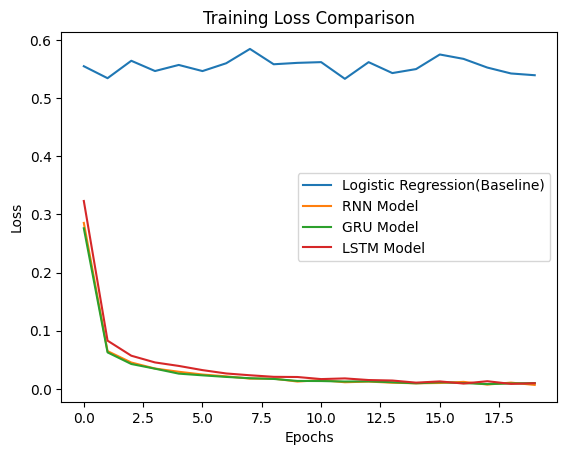

In [ ]:
plt.plot(linear_loss, label='Logistic Regression(Baseline)')
plt.plot(rnn_loss, label='RNN Model')
plt.plot(gru_loss, label='GRU Model')
plt.plot(lstm_loss, label='LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()

Loss function for RNN, GRU and LSTM are very similar and all are decreasing with increasing number of epochs and reaching to a saturation.

Also, the baseline model has not performed well since the loss is not decreasing any more with increasing number of epochs

### Observation and Final Model

**The Final model with best performance is GRU Model with accuracy of 99.18% on test Set**

In [ ]:
#analysing model dictionary
print("Model's state_dict:")
for param_tensor in gru_model.state_dict():
    print(param_tensor, "\t", gru_model.state_dict()[param_tensor].size())

#saving gru model
final_mnist_model = torch.save(gru_model.state_dict(), "gru_model.pth")

Model's state_dict:
gru.weight_ih_l0 	 torch.Size([768, 28])
gru.weight_hh_l0 	 torch.Size([768, 256])
gru.bias_ih_l0 	 torch.Size([768])
gru.bias_hh_l0 	 torch.Size([768])
gru.weight_ih_l1 	 torch.Size([768, 256])
gru.weight_hh_l1 	 torch.Size([768, 256])
gru.bias_ih_l1 	 torch.Size([768])
gru.bias_hh_l1 	 torch.Size([768])
fc.weight 	 torch.Size([10, 256])
fc.bias 	 torch.Size([10])


1. Linear Model is simple but lacks temporal understanding.
RNN Model captures sequence information, improving accuracy.
The loss plot visually shows performance differences.

2. The GRU model outperforms the baseline Linear, RNN, and LSTM models in terms of accuracy. The GRU model effectively captures sequential dependencies and maintains stability during training, leading to better generalization on the MNIST dataset.

3. LSTM has outperformed simple RNN and Logistic Regression Model in terms of accuracy

4. Further future work can be performed where by changing the hyperparameter such as batch_size, learning_rate and shuffle, normalization could also impact the result. According to the loss function and the accuracy achieved we have classfied MNIST dataset with epochs less than 30 and learning rate  0.001.



Submitted By: Khushi Kala